In [60]:
!pip install lime

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("/kaggle/input/deepfake-faces/metadata.csv")
df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [3]:
def classify_features(df):
    catagorical_feature=[]
    non_catagorical_feature=[]
    discret_feature=[]
    continous_feature=[]
    for column in df.columns:
        if df[column].dtype=="object":
            if df[column].nunique()<10:
                catagorical_feature.append(column)
            else:
                non_catagorical_feature.append(column)
        elif df[column].dtype in ["int64","float64"]:
            if df[column].nunique()<10:
                discret_features.append(column)
            else:
                continous_feature.append(column)
    return catagorical_feature,non_catagorical_feature,discret_feature,continous_feature

In [4]:
catagorical,non_catagorical,discret,continous=classify_features(df)

print("catagorical: ",catagorical)
print("non_catagorical: ",non_catagorical)
print("discret: ",discret)
print("continous: ",continous)

catagorical:  ['label']
non_catagorical:  ['videoname', 'original']
discret:  []
continous:  ['original_width', 'original_height']


In [5]:
df.isna().sum()

videoname              0
original_width         0
original_height        0
label                  0
original           16293
dtype: int64

In [6]:
df=df.fillna("Not Available")

In [7]:
for i in catagorical:
    print(i,':', df[i].unique())
    print()
for i in catagorical:
    print(df[i].value_counts())
    print()

label : ['FAKE' 'REAL']

label
FAKE    79341
REAL    16293
Name: count, dtype: int64



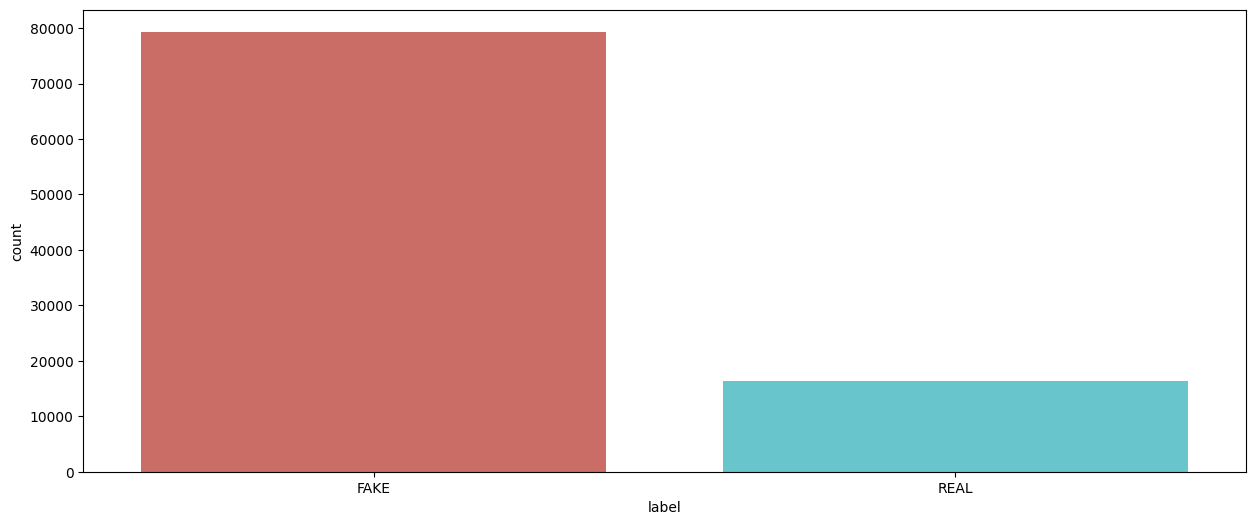

In [8]:
for i in catagorical:
    plt.figure(figsize=(15,6))
    sns.countplot(x = df[i], data = df, palette = 'hls')
    plt.show()

Data Balancing


In [9]:
real_df = df[df["label"] == "REAL"]
fake_df = df[df["label"] == "FAKE"]
sample_size = 10000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [10]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])
Train_set.shape,Val_set.shape,Test_set.shape

((11200, 5), (4800, 5), (4000, 5))

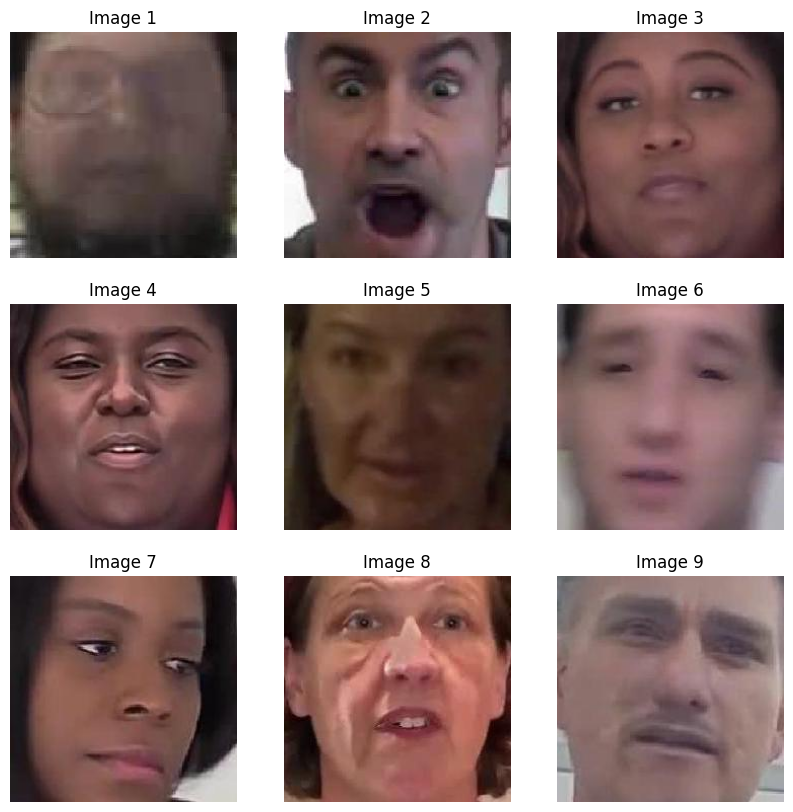

In [11]:
import cv2

image_path="/kaggle/input/deepfake-faces/faces_224/"

image_file=os.listdir(image_path)
image_file.sort()
selected_image=image_file[:9]

plt.figure(figsize=(10,10))

for index,image_file in enumerate(selected_image):
    image=cv2.imread(os.path.join(image_path,image_file))
    plt.subplot(3,3,index+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {index + 1}')
    plt.axis('off')

plt.show()

In [12]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [13]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from functools import partial

tf.random.set_seed(42)

2025-09-23 05:46:53.513236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758606413.687765      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758606413.739889      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
IMAGE_SIZE=224
BATCH_SIZE=32
EPOCHS=10

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Save the best model based on validation loss
def get_callbacks(name):
    checkpoint_cb = ModelCheckpoint(
        filepath=f'best_model_{name}.h5',          # Use '.keras' if using newer TF versions
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Stop training early if validation loss doesn't improve
    earlystop_cb = EarlyStopping(
        monitor='val_loss',
        patience=3,       # Number of epochs with no improvement
        restore_best_weights=True,
        verbose=1
    )

    # Reduce learning rate when validation loss plateaus
    reduce_lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Combine all callbacks
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

    return callbacks

In [17]:
DefaultConv2D = partial(layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

# Model Definition
model = models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(units=128, activation="relu",
                 kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=64, activation="relu",
                 kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(units=1, activation="sigmoid")
])

I0000 00:00:1758606425.304481      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758606425.305187      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [18]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,621,121 (196.92 MB)

 Trainable params: 51,620,353 (196.92 MB)

 Non-trainable params: 768 (3.00 KB)

In [21]:
history = model.fit(
    X_train, 
    y_train,
    epochs=10,
    callbacks=get_callbacks('custom'),
    batch_size=BATCH_SIZE,
    validation_data=(X_val,y_val),
    verbose=1
)

Epoch 1/10


I0000 00:00:1758606435.790639     101 service.cc:148] XLA service 0x7e9ab4006430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758606435.791181     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758606435.791225     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758606436.312170     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758606450.879275     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5246 - loss: 0.9344 - precision: 0.5306 - recall: 0.5318
Epoch 1: val_loss improved from inf to 0.79419, saving model to best_model_custom.h5
350/350 ━━━━━━━━━━━━━━━━━━━━ 85s 184ms/step - accuracy: 0.5247 - loss: 0.9341 - precision: 0.5306 - recall: 0.5319 - val_accuracy: 0.5221 - val_loss: 0.7942 - val_precision: 0.5798 - val_recall: 0.1604 - learning_rate: 0.0010
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5587 - loss: 0.7276 - precision: 0.5658 - recall: 0.5567
Epoch 2: val_loss improved from 0.79419 to 0.65845, saving model to best_model_custom.h5
350/350 ━━━━━━━━━━━━━━━━━━━━ 61s 175ms/step - accuracy: 0.5587 - loss: 0.7276 - precision: 0.5658 - recall: 0.5567 - val_accuracy: 0.5979 - val_loss: 0.6584 - val_precision: 0.5641 - val_recall: 0.8612 - learning_rate: 0.0010
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6110 - loss: 0.6655 - precision: 0.6107 - recall: 0.6406
Epoch 3: v

In [22]:
y_pred = model.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step


In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

In [24]:
y_test_pred_binary = (y_pred > 0.5).astype(int)

In [25]:
y_train_pred = model.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step


In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 72.52%


In [27]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 66.40%


In [28]:
f1 = f1_score(y_test, y_test_pred_binary)
print(f"F1 Score: {f1:.4f}")

precision = precision_score(y_test, y_test_pred_binary)
print(f"Precison: {precision:.4f}")

recall = recall_score(y_test, y_test_pred_binary)
print(f"Recall: {recall:.4f}")

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_test_pred_binary)
print(f"AUC-ROC: {auc_roc:.4f}")

F1 Score: 0.6201
Precison: 0.7133
Recall: 0.5485
AUC-ROC: 0.6640


In [29]:
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1559  441]
 [ 903 1097]]


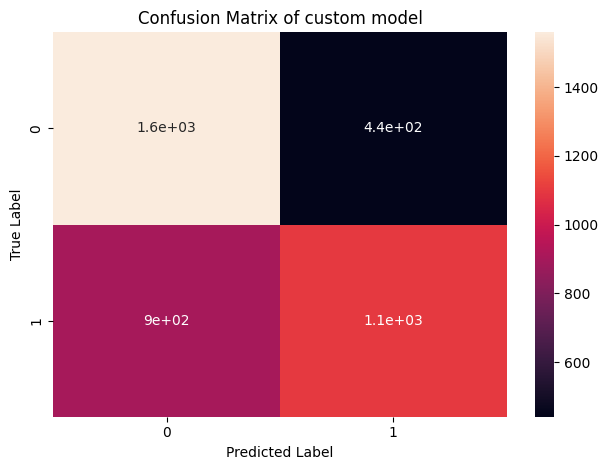

In [30]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of custom model')
plt.tight_layout()
plt.show()

In [31]:
class_report = classification_report(y_test, y_test_pred_binary)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      2000
           1       0.71      0.55      0.62      2000

    accuracy                           0.66      4000
   macro avg       0.67      0.66      0.66      4000
weighted avg       0.67      0.66      0.66      4000



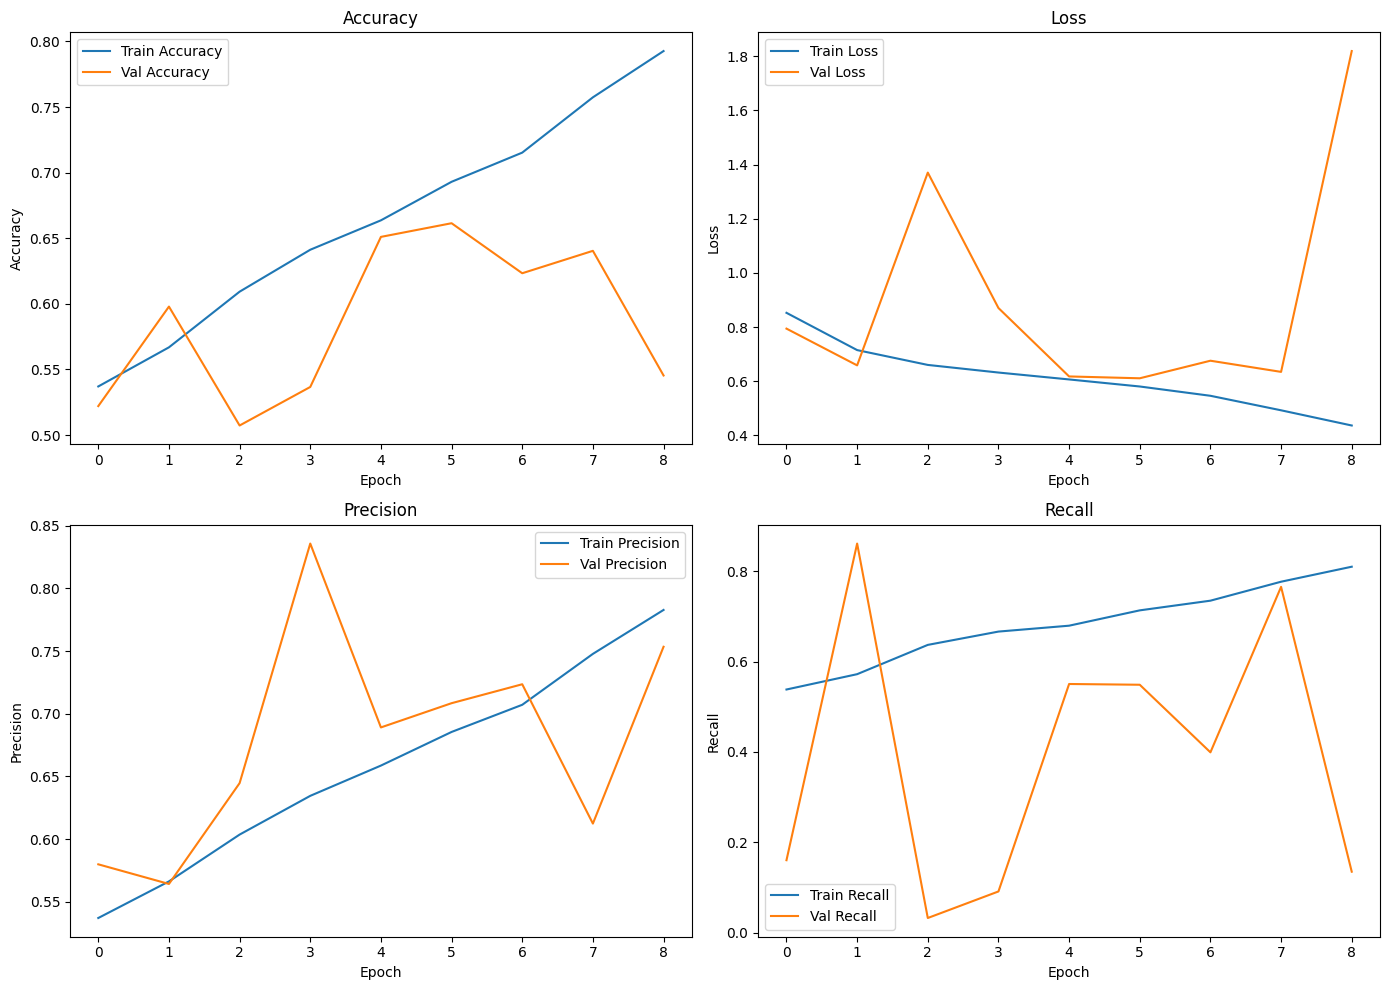

In [32]:
import matplotlib.pyplot as plt

# Unpack training history
hist = history.history

# Create 2x2 subplot
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(hist['precision'], label='Train Precision')
plt.plot(hist['val_precision'], label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(hist['recall'], label='Train Recall')
plt.plot(hist['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
model.save("custom_model_ep10.keras")

In [34]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

for layer in base_model.layers:
    layer.trainable = False
    
model_resnet50 = models.Sequential()
model_resnet50.add(base_model)
model_resnet50.add(layers.GlobalAveragePooling2D())
model_resnet50.add(layers.Dense(1, activation='sigmoid'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [35]:
model_resnet50.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [36]:
from tensorflow.keras import optimizers

model_resnet50.compile(
    optimizer="adam", 
    loss='binary_crossentropy', 
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

In [37]:
history = model_resnet50.fit(
    X_train, y_train,
    epochs=10,  
    callbacks=get_callbacks('resnet50'),
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5700 - loss: 0.6927 - precision: 0.5758 - recall: 0.5795
Epoch 1: val_loss improved from inf to 0.60883, saving model to best_model_resnet50.h5
350/350 ━━━━━━━━━━━━━━━━━━━━ 62s 136ms/step - accuracy: 0.5701 - loss: 0.6926 - precision: 0.5759 - recall: 0.5796 - val_accuracy: 0.6702 - val_loss: 0.6088 - val_precision: 0.6588 - val_recall: 0.7063 - learning_rate: 0.0010
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6648 - loss: 0.6096 - precision: 0.6671 - recall: 0.6752
Epoch 2: val_loss improved from 0.60883 to 0.59250, saving model to best_model_resnet50.h5
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.6648 - loss: 0.6096 - precision: 0.6671 - recall: 0.6752 - val_accuracy: 0.6812 - val_loss: 0.5925 - val_precision: 0.6693 - val_recall: 0.7167 - learning_rate: 0.0010
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6829 - loss: 0.5871 - precision: 0.6847 - recall: 0.693

In [38]:
y_pred = model_resnet50.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step


In [39]:
y_test_pred_binary = (y_pred > 0.5).astype(int)

In [40]:
y_train_pred = model_resnet50.predict(X_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)

350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step


In [41]:
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 75.61%


In [42]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 71.15%


In [43]:
f1 = f1_score(y_test, y_test_pred_binary)
print(f"F1 Score: {f1:.4f}")

precision = precision_score(y_test, y_test_pred_binary)
print(f"Precison: {precision:.4f}")

recall = recall_score(y_test, y_test_pred_binary)
print(f"Recall: {recall:.4f}")

F1 Score: 0.7126
Precison: 0.7098
Recall: 0.7155


In [44]:
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1415  585]
 [ 569 1431]]


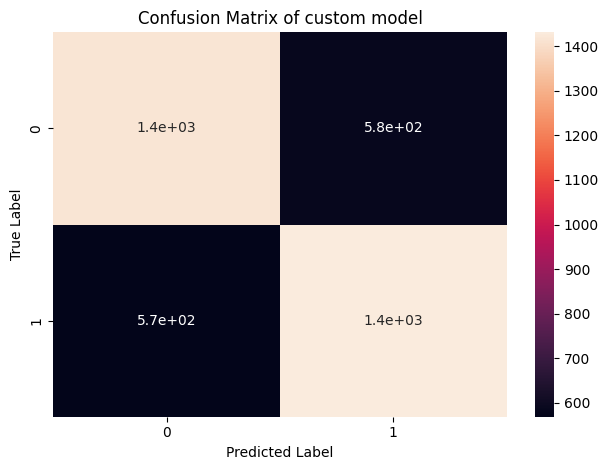

In [45]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of custom model')
plt.tight_layout()
plt.show()

In [46]:
class_report = classification_report(y_test, y_test_pred_binary)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2000
           1       0.71      0.72      0.71      2000

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000



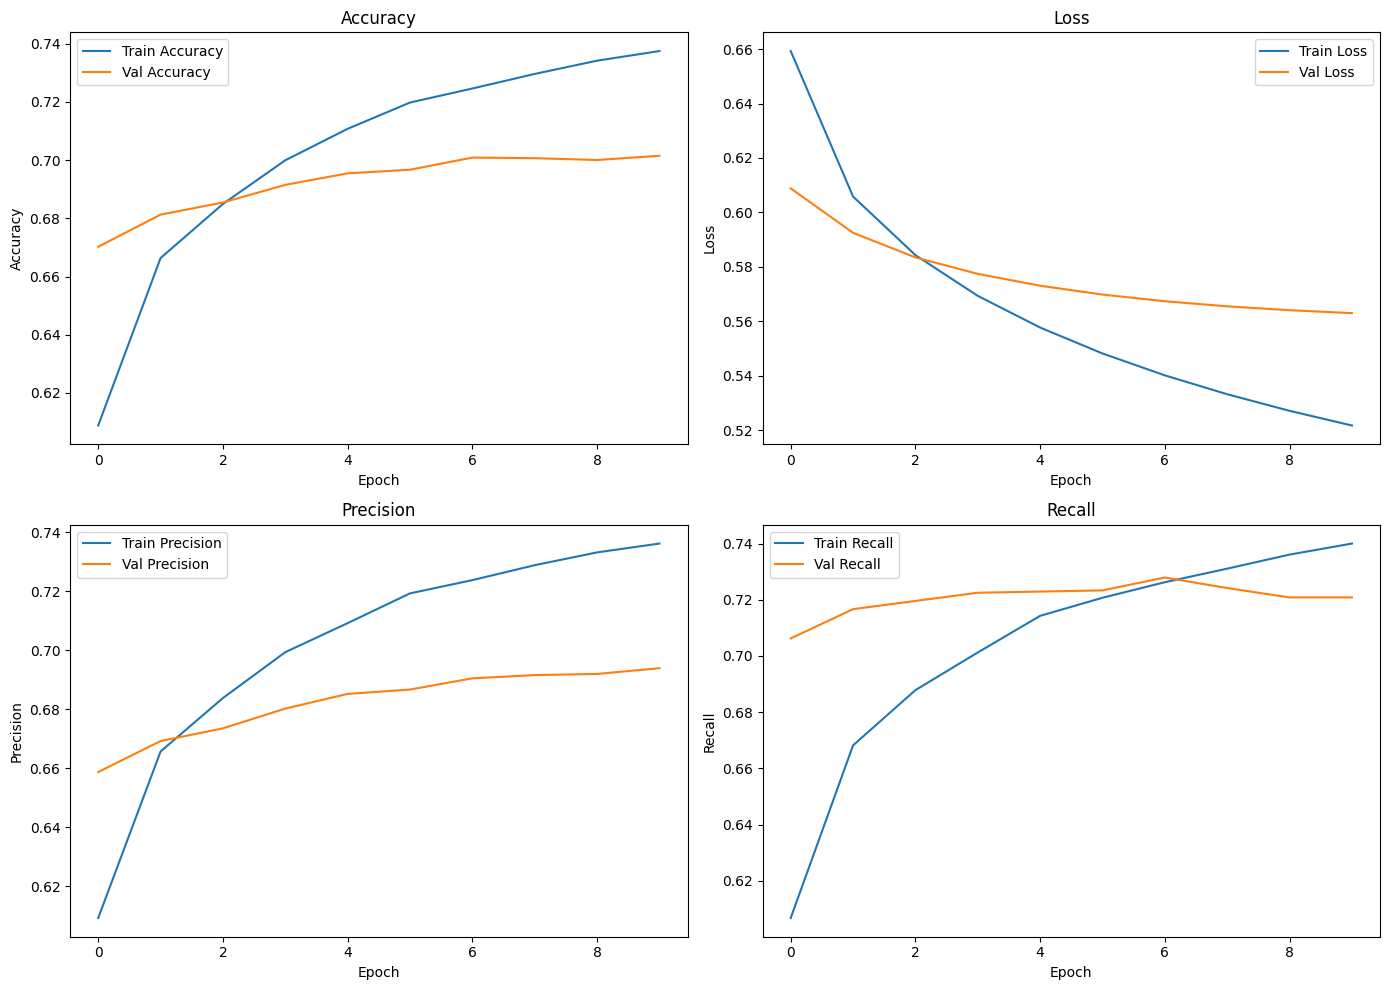

In [47]:
import matplotlib.pyplot as plt

# Unpack training history
hist = history.history

# Create 2x2 subplot
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(hist['precision'], label='Train Precision')
plt.plot(hist['val_precision'], label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(hist['recall'], label='Train Recall')
plt.plot(hist['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
model.save("resnet50_model_ep10.keras")

In [65]:
import cv2
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [66]:
# Create LIME explainer
lime_explainer = lime_image.LimeImageExplainer()

def preprocess_frame(frame):
    frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    frame = frame.astype("float32") / 255.0
    return frame

def explain_frame(frame):
    # frame: (224,224,3) in [0-255]
    def predict_fn(images):
        images = np.array(images) / 255.0  # normalize
        return model.predict(images)

    explanation = lime_explainer.explain_instance(
        frame, 
        predict_fn, 
        top_labels=1, 
        hide_color=0, 
        num_samples=1000
    )
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label, 
        positive_only=False, 
        num_features=10, 
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis("off")
    plt.show()



In [67]:
def predict_video(video_path, show_explanations=False):
    cap = cv2.VideoCapture(video_path)
    preds = []
    count = 0
    
    while cap.isOpened() and count < MAX_FRAMES:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = preprocess_frame(frame)   # normalized [0-1]
        frame_input = np.expand_dims(frame_resized, axis=0)  # shape (1,224,224,3)
        
        pred = model.predict(frame_input, verbose=0)[0][0]
        preds.append(pred)
        
        # Show LIME explanation every 10th frame
        if show_explanations and count % 10 == 0:
            print(f"Explaining frame {count}...")
            explain_frame((frame_resized * 255).astype(np.uint8))  # back to [0-255]
        
        count += 1

    cap.release()
    
    avg_score = np.mean(preds) if preds else 0.0
    return ("FAKE" if avg_score > 0.5 else "REAL"), avg_score



In [68]:
# --- Parameters ---
video_path = "/kaggle/input/deepfake-detection-challenge/train_sample_videos/abqwwspghj.mp4"
IMG_SIZE = 224
MAX_FRAMES = 30

Explaining frame 0...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

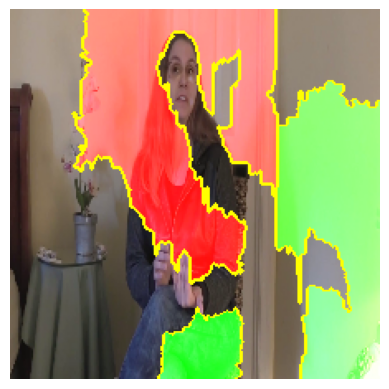

Explaining frame 10...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

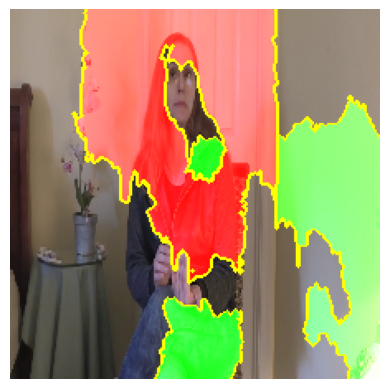

Explaining frame 20...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

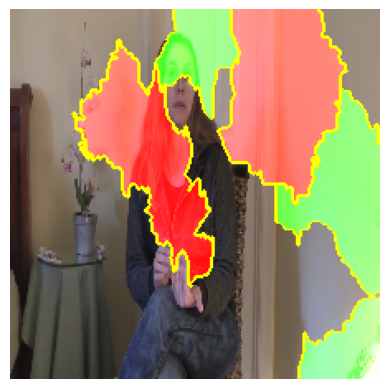

Prediction: FAKE (confidence: 0.5130)


In [69]:
# --- Run prediction ---
label, score = predict_video(video_path, show_explanations=True)
print(f"Prediction: {label} (confidence: {score:.4f})")


In [70]:
model.save("deepfake_resnet50.h5")

In [72]:
from IPython.display import FileLink

# This will create the download link for your file
FileLink("/kaggle/working/deepfake_resnet50.h5")

/kaggle/working/deepfake_resnet50.h5